In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

2024-05-05 15:58:29.404511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 15:58:29.404620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 15:58:29.529020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
filelist_trainx = sorted(glob.glob('/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/*.jpg'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1_Training_GroundTruth/*.png'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

In [4]:
print("Size of X_train:", X_train.shape)
print("Size of Y_train:", Y_train.shape)

Size of X_train: (2594, 224, 224, 3)
Size of Y_train: (2594, 224, 224)


In [6]:
def resize(filename, size = (256,192)):
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    return (im_resized)

In [7]:
X_train_ph2_resized = []
Y_train_ph2_resized = []

for i in range(len(filelist_trainx)):
    X_train_ph2_resized.append(resize(filelist_trainx[i]))
    Y_train_ph2_resized.append(resize(filelist_trainy[i]))

In [9]:
X_train_ph2 = np.array([np.array(img) for img in X_train_ph2_resized])
Y_train_ph2 = np.array([np.array(img) for img in Y_train_ph2_resized])

In [10]:
print("Size of X_train:", X_train_ph2.shape)
print("Size of Y_train:", Y_train_ph2.shape)

Size of X_train: (2594, 192, 256, 3)
Size of Y_train: (2594, 192, 256)


In [11]:
filelist_trainx = sorted(glob.glob('/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Test_Input/*.jpg'), key=numericalSort)
X_test = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('//kaggle/input/another/another/ISIC2018_Task1_Test_GroundTruth/*.png'), key=numericalSort)
Y_test = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

In [12]:
print("Size of X_train:", X_test.shape)
print("Size of Y_train:", Y_test.shape)

Size of X_train: (1000, 224, 224, 3)
Size of Y_train: (1000, 224, 224)


In [13]:
X_test_ph2_resized = []
Y_test_ph2_resized = []

for i in range(len(filelist_trainx)):
    X_test_ph2_resized.append(resize(filelist_trainx[i]))
    Y_test_ph2_resized.append(resize(filelist_trainy[i]))

In [14]:
X_test_ph2 = np.array([np.array(img) for img in X_test_ph2_resized])
Y_test_ph2 = np.array([np.array(img) for img in Y_test_ph2_resized])

In [15]:
print("Size of X_train:", X_test_ph2.shape)
print("Size of Y_train:", Y_test_ph2.shape)

Size of X_train: (1000, 192, 256, 3)
Size of Y_train: (1000, 192, 256)


In [16]:
def iou(y_true, y_pred, smooth = 100):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [17]:
def dice_coef(y_true, y_pred, smooth = 100):
     
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, dtype='float32')
    y_pred_f = K.cast(y_pred_f, dtype='float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [18]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [19]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [20]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [20]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [21]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [22]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(X_train_ph2, Y_train_ph2)

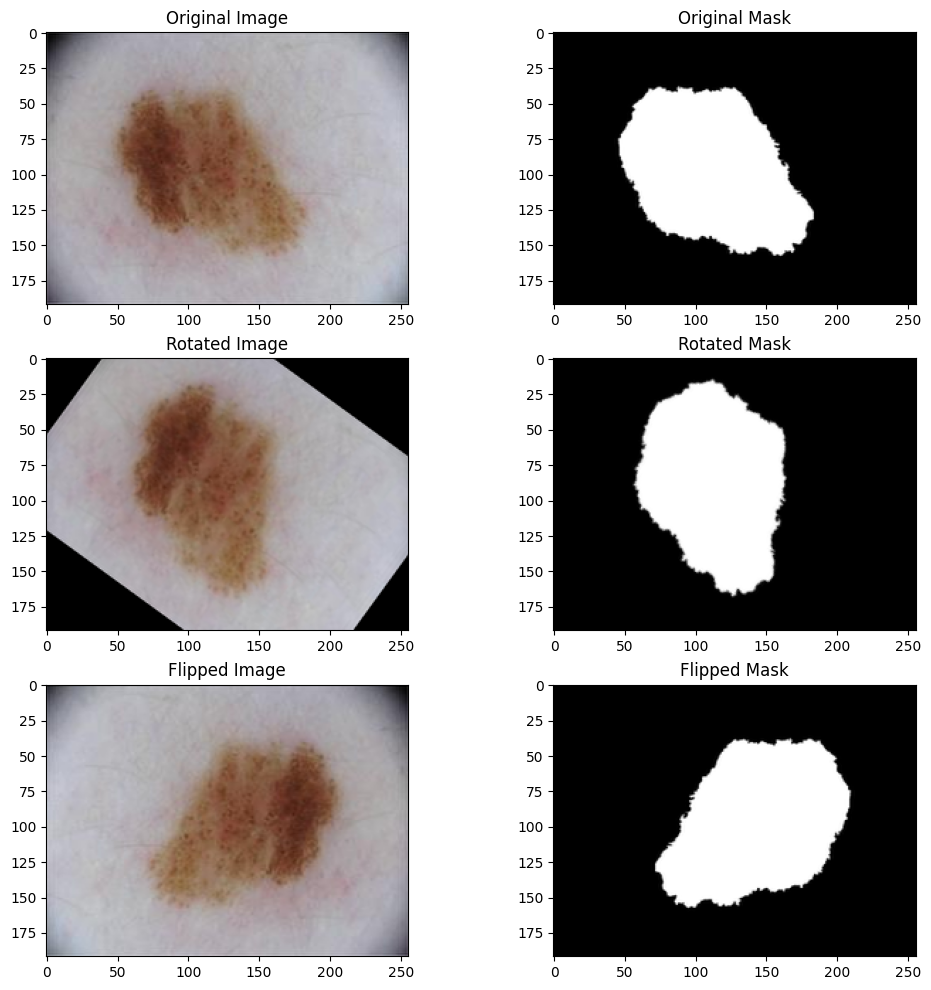

In [23]:
img_num = 7
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(X_train_ph2[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(Y_train_ph2[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

In [24]:
x_train_full = np.concatenate([X_train_ph2, x_rotated, x_flipped])
y_train_full = np.concatenate([Y_train_ph2, y_rotated, y_flipped])

In [21]:
x_train, x_val, y_train, y_val = train_test_split(X_train_ph2, Y_train_ph2, test_size = 0.20, random_state = 101)

In [26]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(X_test_ph2)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 6225
Length of the Test Set       : 1000
Length of the Validation Set : 1557


In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Conv2DTranspose, BatchNormalization, Activation, Dense, Reshape

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, Accuracy

def segnet_transfer_learning(weights_path, epochs_num, savename):

    # Encoding layer
    img_input = Input(shape= (192, 256, 3))

    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)

    model = Model(inputs=img_input, outputs=pred)

    model.load_weights(weights_path)

    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.9), loss=["binary_crossentropy"],
              metrics=[iou, dice_coef, Precision(), Recall(), accuracy])
    model.summary()
    checkpoint = ModelCheckpoint(savename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]

    hist = model.fit(x_train, y_train, epochs=epochs_num, batch_size=18, 
                     validation_data=(x_val, y_val), verbose=1,
                     callbacks=callbacks_list)

    model.save('/kaggle/working/' + savename)
    return model,hist

In [23]:
weights_path = '/kaggle/input/segnet_ph2/tensorflow2/transfer_segnet_100/1/transfer_segnet_100_epo.keras'  # Path to the pre-trained weights
epochs_num = 1  # Number of epochs for fine-tuning 
savename = 'retrain_segnet_isic_2018_1_ep.keras'  # Path to save the trained model

# Call the function
model, history = segnet_transfer_learning(weights_path, epochs_num, savename)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 192, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 192, 256, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 192, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 192, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 192, 256, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 192, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 96, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 96, 128, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 96, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 96, 128, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 96, 128, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 96, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 48, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn6 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn7 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 32, 256)    │             

 Total params: 33,393,669 (127.39 MB)

 Trainable params: 33,377,795 (127.33 MB)

 Non-trainable params: 15,874 (62.01 KB)

2024-05-05 16:01:06.521208: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49152: 2.23176, expected 1.27425
2024-05-05 16:01:06.521262: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49153: 4.15262, expected 3.19511
2024-05-05 16:01:06.521271: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49154: 4.28259, expected 3.32508
2024-05-05 16:01:06.521279: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49155: 4.84574, expected 3.88822
2024-05-05 16:01:06.521286: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49156: 4.56285, expected 3.60534
2024-05-05 16:01:06.521301: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49157: 3.73815, expected 2.78063
2024-05-05 16:01:06.521309: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49158: 4.70149, expected 3.74397
2024-05-05 16:01:06.521316:

115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.7294 - dice_coef: 1.7647 - iou: 0.4083 - loss: -242.9193 - precision: 0.8048 - recall: 0.8493

2024-05-05 16:02:21.877098: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.77932, expected 2.15864
2024-05-05 16:02:21.877163: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.13203, expected 3.51135
2024-05-05 16:02:21.877194: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.19614, expected 4.57546
2024-05-05 16:02:21.877208: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.74807, expected 4.12739
2024-05-05 16:02:21.877220: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.11112, expected 4.49044
2024-05-05 16:02:21.877231: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.64802, expected 4.02734
2024-05-05 16:02:21.877242: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.48129, expected 3.86061
2024-05-05 16:02:21.877253: E external/local_xla/xla/se

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.7295 - dice_coef: 1.7650 - iou: 0.4084 - loss: -242.9989 - precision: 0.8049 - recall: 0.8495

2024-05-05 16:02:50.177176: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.2972, expected 1.35512
2024-05-05 16:02:50.177262: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.29035, expected 2.34827
2024-05-05 16:02:50.177272: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.25674, expected 3.31466
2024-05-05 16:02:50.177281: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.35661, expected 2.41453
2024-05-05 16:02:50.177289: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.61109, expected 2.66901
2024-05-05 16:02:50.177297: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.35577, expected 2.41369
2024-05-05 16:02:50.177305: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.76801, expected 2.82593
2024-05-05 16:02:50.177313: E external/local_xla/xla/ser


Epoch 1: val_loss improved from inf to -457.45642, saving model to retrain_segnet_isic_2018_1_ep.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 137s 643ms/step - accuracy: 0.7295 - dice_coef: 1.7653 - iou: 0.4084 - loss: -243.0771 - precision: 0.8051 - recall: 0.8497 - val_accuracy: 0.7190 - val_dice_coef: 1.8035 - val_iou: 0.4068 - val_loss: -457.4564 - val_precision: 0.8781 - val_recall: 0.8774


In [24]:
# Example usage
weights_path = '/kaggle/input/segnet_ph2/tensorflow2/transfer_segnet_100/1/transfer_segnet_100_epo.keras'  # Path to the pre-trained weights
epochs_num = 50  # Number of epochs for fine-tuning
savename = 'segnet_isic2018_50.keras'  # Path to save the trained model

# Call the function
model, history = segnet_transfer_learning(weights_path, epochs_num, savename)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 192, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 192, 256, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 192, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 192, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 192, 256, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 192, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 96, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 96, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 96, 128, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 96, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 96, 128, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 96, 128, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 96, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 48, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 48, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn6 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn7 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 32, 256)    │             

 Total params: 33,393,669 (127.39 MB)

 Trainable params: 33,377,795 (127.33 MB)

 Non-trainable params: 15,874 (62.01 KB)

Epoch 1/50


W0000 00:00:1714925019.737564     577 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7362 - dice_coef: 1.7684 - iou: 0.4113 - loss: -244.1544 - precision_1: 0.8136 - recall_1: 0.8537
Epoch 1: val_loss improved from inf to -327.24631, saving model to segnet_isic2018_50.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 77s 433ms/step - accuracy: 0.7362 - dice_coef: 1.7687 - iou: 0.4113 - loss: -244.2327 - precision_1: 0.8137 - recall_1: 0.8540 - val_accuracy: 0.7315 - val_dice_coef: 1.7328 - val_iou: 0.4146 - val_loss: -327.2463 - val_precision_1: 0.9213 - val_recall_1: 0.8342
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.7392 - dice_coef: 1.8444 - iou: 0.4112 - loss: -267.6767 - precision_1: 0.8622 - recall_1: 0.9092
Epoch 2: val_loss did not improve from -327.24631
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 294ms/step - accuracy: 0.7393 - dice_coef: 1.8445 - iou: 0.4113 - loss: -267.6809 - precision_1: 0.8622 - recall_1: 0.9092 - val_accuracy: 0.7357 - val_dice_coef: 1.6735 - val_iou: 0.4114 - val_loss: -213.1501 - 

In [25]:
# Encoding layer
img_input = Input(shape= (192, 256, 3))
x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
x = BatchNormalization(name='bn9')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
x = BatchNormalization(name='bn10')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
x = BatchNormalization(name='bn11')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
x = BatchNormalization(name='bn12')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
x = BatchNormalization(name='bn13')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dense(1024, activation = 'relu', name='fc1')(x)
x = Dense(1024, activation = 'relu', name='fc2')(x)
# Decoding Layer
x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn14')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn15')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn16')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='bn17')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
x = BatchNormalization(name='bn18')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
x = BatchNormalization(name='bn19')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
x = BatchNormalization(name='bn20')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
x = BatchNormalization(name='bn21')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
x = BatchNormalization(name='bn22')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
x = BatchNormalization(name='bn23')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
x = BatchNormalization(name='bn24')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
x = BatchNormalization(name='bn25')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
x = BatchNormalization(name='bn26')(x)
x = Activation('sigmoid')(x)
pred = Reshape((192,256))(x)

In [27]:
from tensorflow.keras.optimizers import SGD
model_1 = Model(inputs=img_input, outputs=pred)
model_1.compile(optimizer= SGD(learning_rate=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss=["binary_crossentropy"] ,
               metrics=[iou, dice_coef, Precision(), Recall(), accuracy])

In [28]:
model_1.load_weights('/kaggle/working/segnet_isic2018_50.keras')

In [32]:
print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(x_train, y_train, batch_size= 16)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100+5))
print("Loss:      |   {:.2f}  |".format(res[0]/100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(X_test_ph2, Y_test_ph2, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100+14))
print("Loss:      |   {:.2f}  |".format(res[0]/100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100+7))
print("Loss:      |   {:.2f}  |".format(res[0]/100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------



2024-05-05 16:40:49.198109: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.90478, expected 2.03346
2024-05-05 16:40:49.198175: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.99251, expected 3.12119
2024-05-05 16:40:49.198185: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.8935, expected 4.02217
2024-05-05 16:40:49.198192: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.22186, expected 4.35054
2024-05-05 16:40:49.198200: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.71088, expected 3.83956
2024-05-05 16:40:49.198208: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.25433, expected 4.38301
2024-05-05 16:40:49.198215: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.486, expected 4.61468
2024-05-05 16:40:49.198222: E external/local_xla/xla/servi

129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7755 - dice_coef: 1.9771 - iou: 0.4206 - loss: -377.5764 - precision_3: 0.9853 - recall_3: 0.9608

2024-05-05 16:41:10.869389: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147456: 3.86168, expected 2.96196
2024-05-05 16:41:10.869447: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147457: 4.21849, expected 3.31878
2024-05-05 16:41:10.869463: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147458: 4.99023, expected 4.09052
2024-05-05 16:41:10.869479: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147459: 6.8136, expected 5.91389
2024-05-05 16:41:10.869494: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147460: 4.65252, expected 3.75281
2024-05-05 16:41:10.869504: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147461: 5.41211, expected 4.5124
2024-05-05 16:41:10.869516: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147462: 5.35406, expected 4.45435
2024-05-05 16:41:10.86

130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - accuracy: 0.7755 - dice_coef: 1.9771 - iou: 0.4205 - loss: -377.6529 - precision_3: 0.9853 - recall_3: 0.9609
________________________
IOU:       |   41.65  |
Dice Coef: |   197.74  |
Precision: |   98.53  |
Recall:    |   96.15  |
Accuracy:  |   82.27  |
Loss:      |   -3.83  |
________________________

-------------On Test  Set--------------------------

56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.6765 - dice_coef: 1.8528 - iou: 0.3289 - loss: -442.6436 - precision_3: 0.8859 - recall_3: 0.8987
________________________
IOU:       |   32.67  |
Dice Coef: |   178.84  |
Precision: |   87.64  |
Recall:    |   85.52  |
Accuracy:  |   80.84  |
Loss:      |   -4.22  |
________________________

-------------On validation Set---------------------

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.7133 - dice_coef: 1.8178 - iou: 0.3714 - loss: -401.3874 - precision_3: 0.9322 - recall_3: 0.8748
________________________
IOU:       |   39

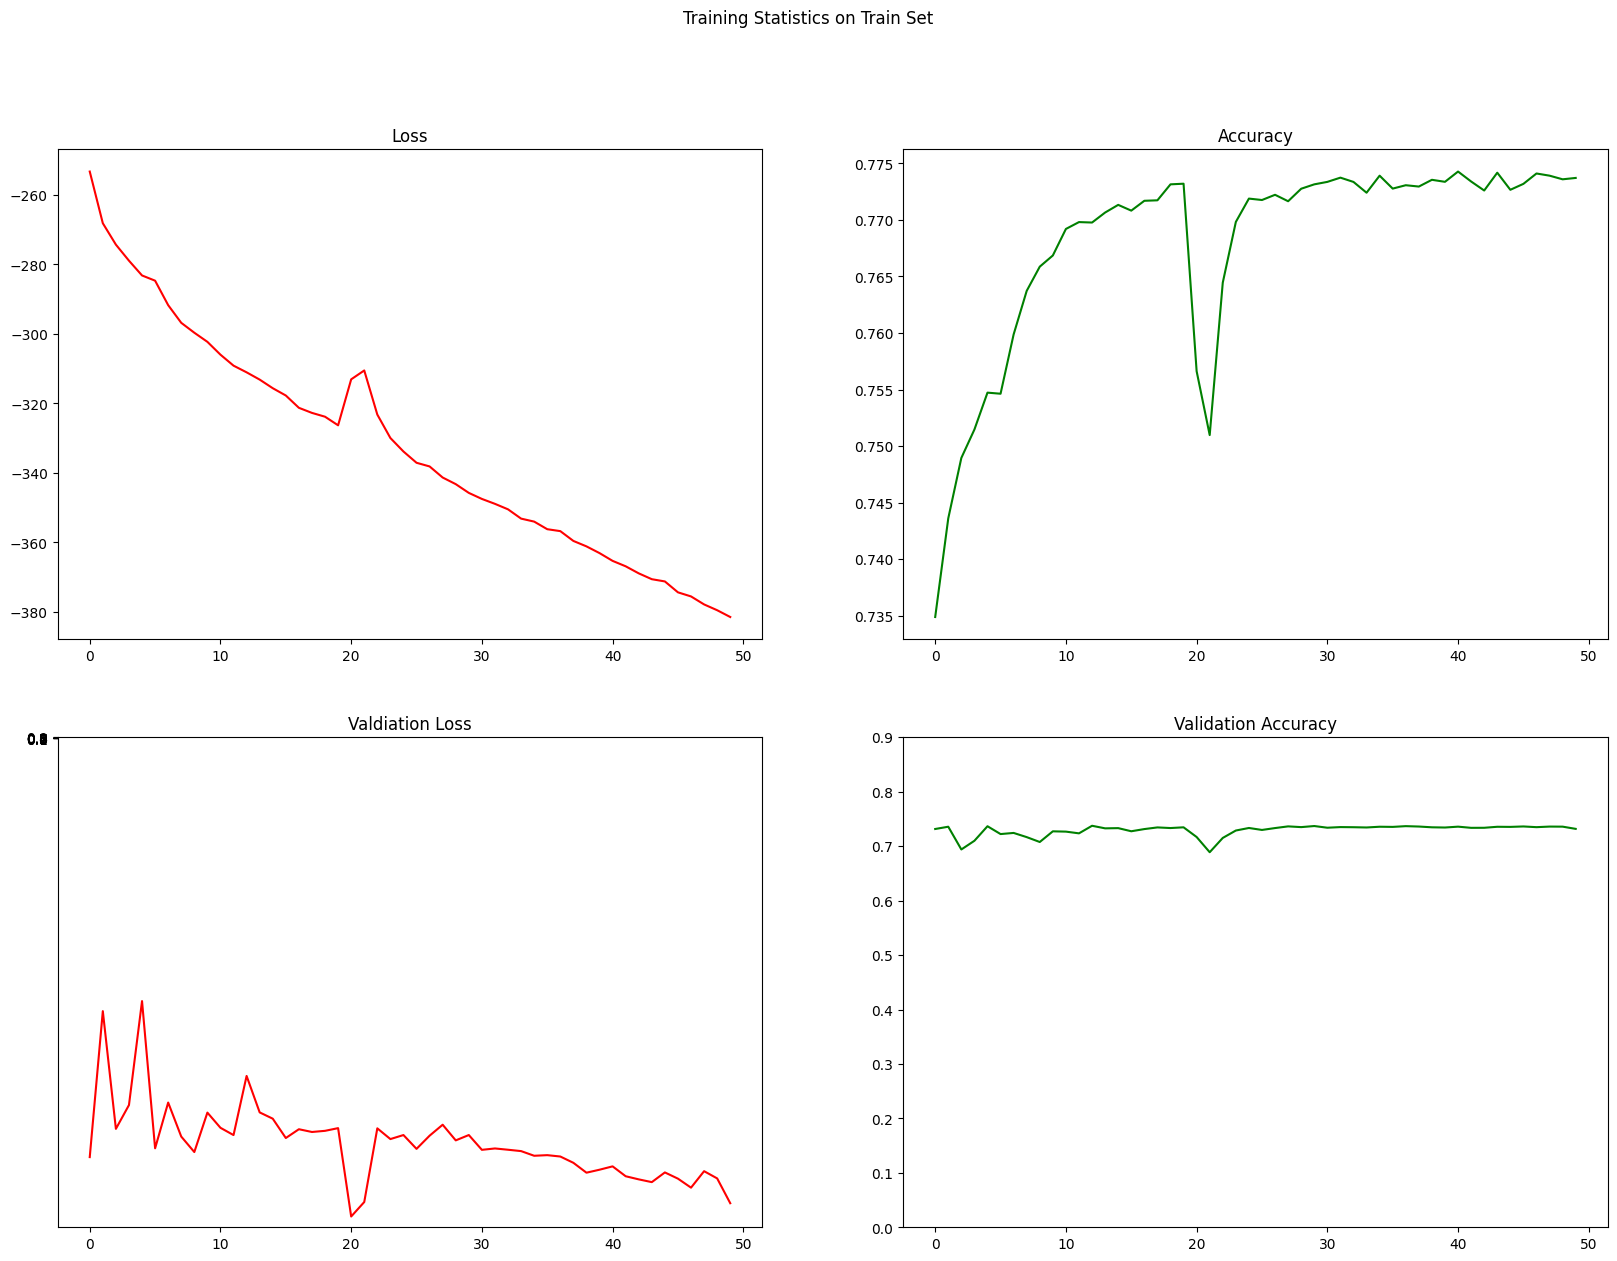

In [33]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(history.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(history.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

2024-05-05 16:44:03.557569: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.05168, expected 1.70188
2024-05-05 16:44:03.557624: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 2.40361, expected 2.0538
2024-05-05 16:44:03.557634: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 2.11563, expected 1.76583
2024-05-05 16:44:03.557876: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49152: 2.46238, expected 1.95727
2024-05-05 16:44:03.557899: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49181: 3.81506, expected 3.30995
2024-05-05 16:44:03.557913: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49182: 3.59659, expected 3.09148
2024-05-05 16:44:03.557925: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49183: 3.68422, expected 3.17911
2024-05-05 16:44:03.557938: E external

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


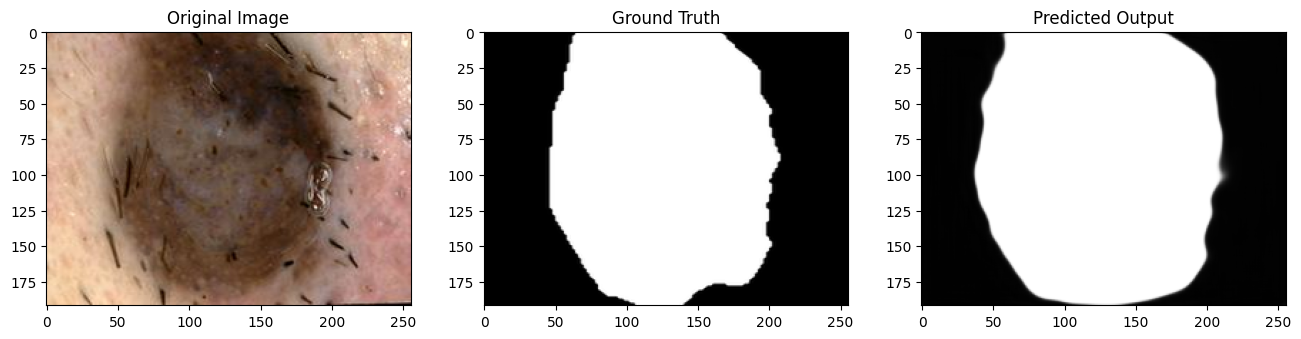

In [35]:
img_num = 49
img_pred = model.predict(X_test_ph2[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_test_ph2[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(Y_test_ph2[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


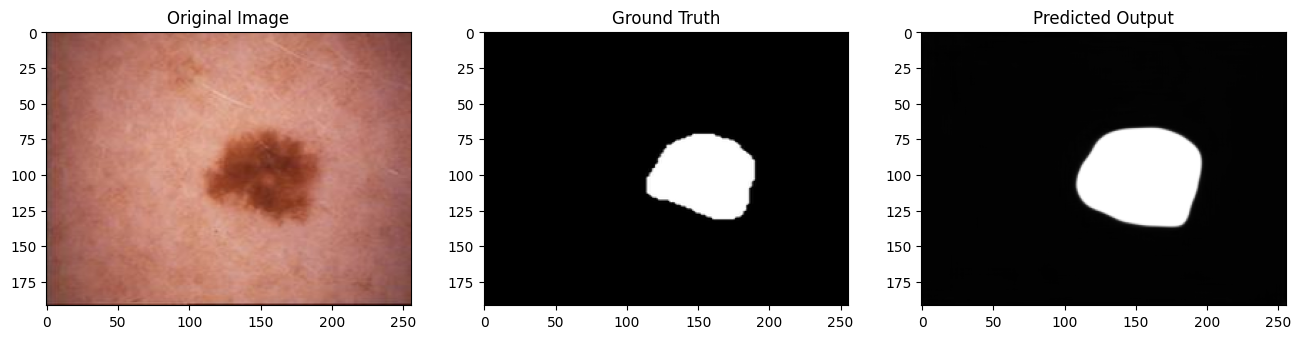

In [36]:
img_num = 360
img_pred = model.predict(X_test_ph2[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_test_ph2[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(Y_test_ph2[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


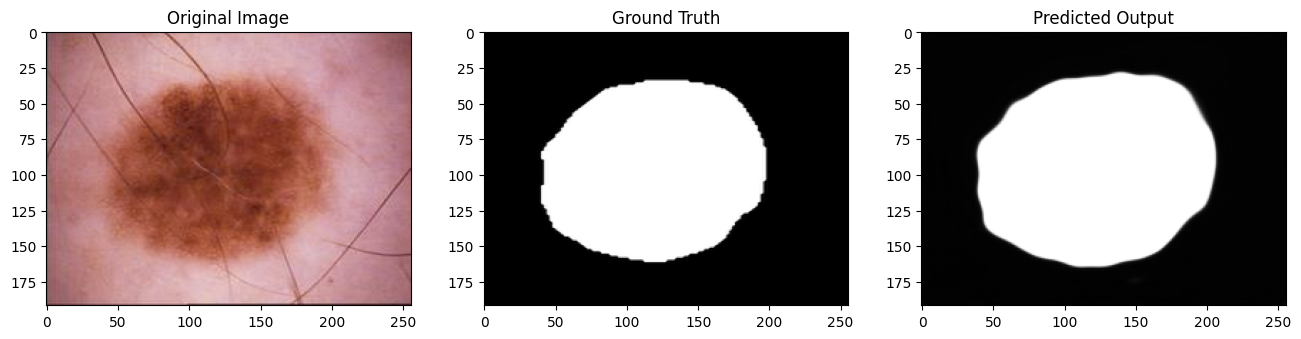

In [37]:
img_num = 415
img_pred = model.predict(X_test_ph2[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_test_ph2[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(Y_test_ph2[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


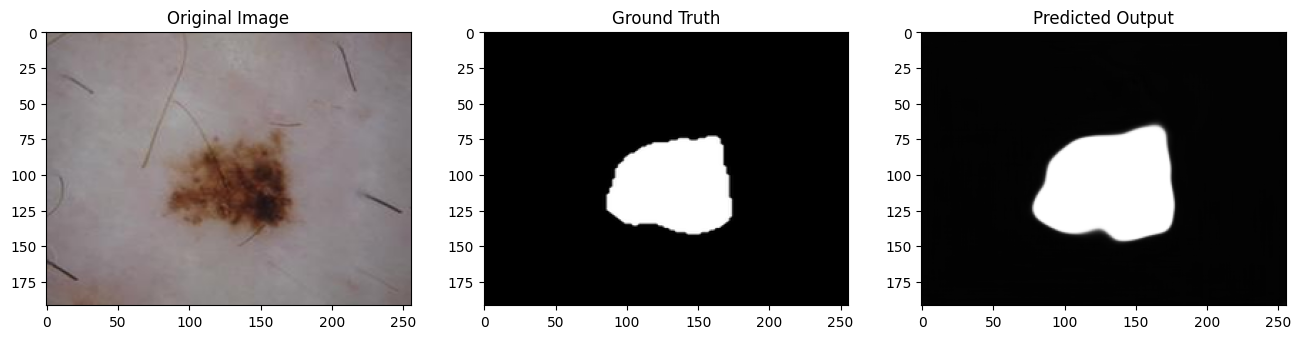

In [41]:
img_num = 941
img_pred = model.predict(X_test_ph2[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_test_ph2[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(Y_test_ph2[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


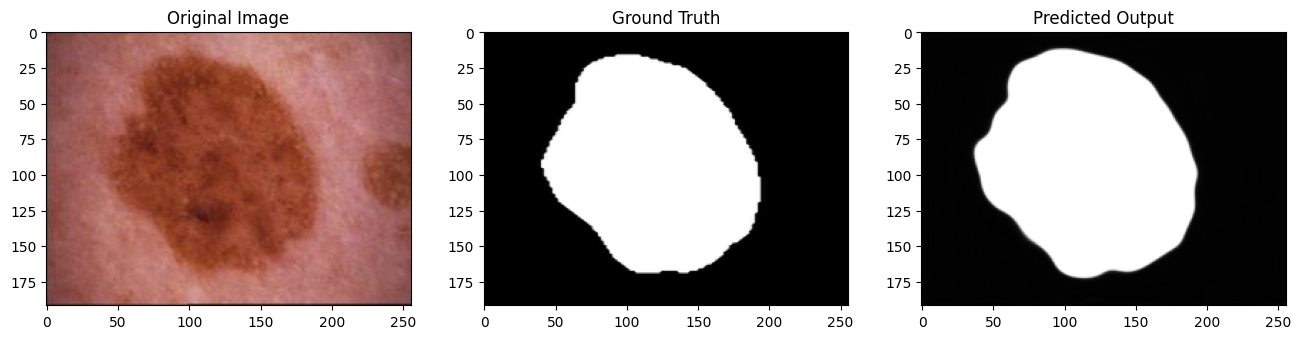

In [42]:
img_num = 334
img_pred = model.predict(X_test_ph2[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_test_ph2[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(Y_test_ph2[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


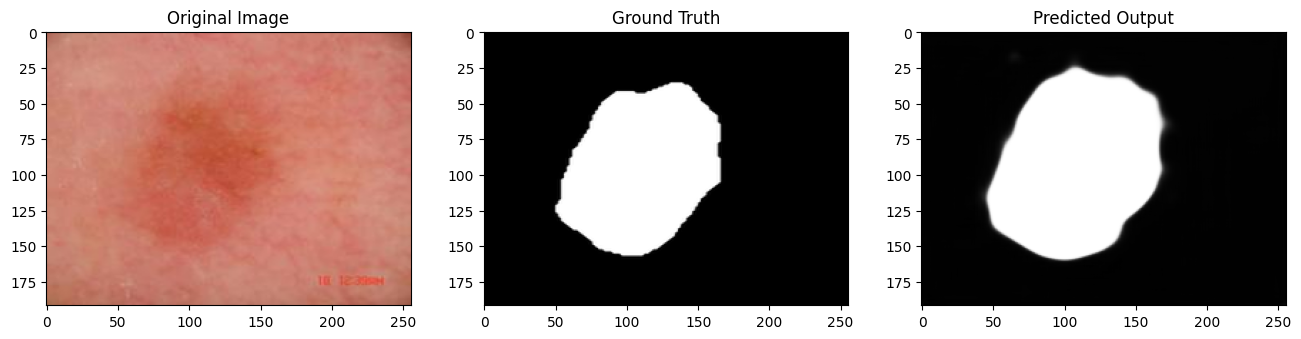

In [43]:
img_num = 457
img_pred = model.predict(X_test_ph2[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_test_ph2[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(Y_test_ph2[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

In [44]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,192,256,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.2:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


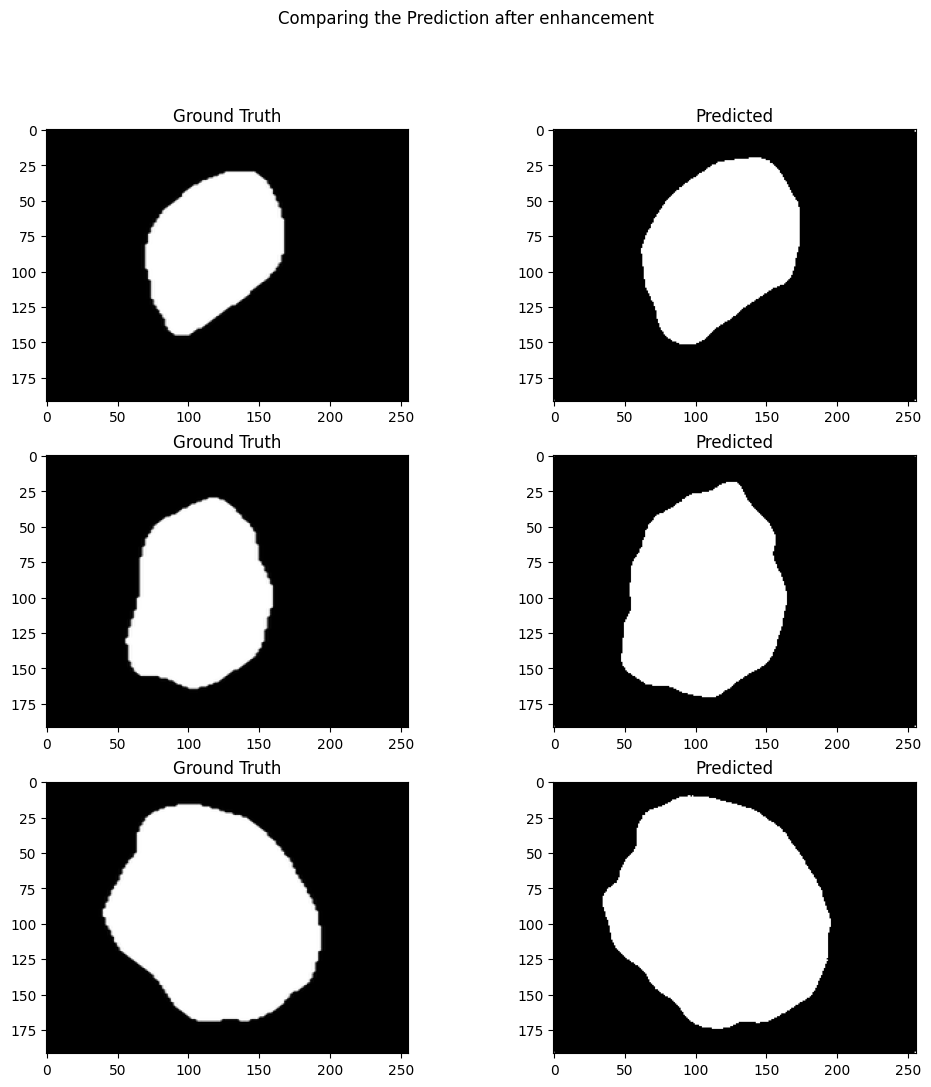

In [48]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(Y_test_ph2[210],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(X_test_ph2[210]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(Y_test_ph2[497],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(X_test_ph2[497]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(Y_test_ph2[334],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(X_test_ph2[334]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.show()